# IN3050/IN4050 Mandatory Assignment 3: Unsupervised Learning

### **Name:** Nora Jeanett Tønnessen

### **Username:** norajto@uio.no

### Goals of the assignment
This assignment has two parts:
1. You will go through the basic theory of **Principal Component Analysis (PCA)** and implement PCA from scratch to compress and visualize data.
2. You will run **K-means clustering** using the `scikit-learn` toolkit and use PCA to visualize the results. You will also evaluate the output of K-means using a multi-class logistic regression classifier.

IN4050 students will have to do one extra part about tuning PCA to balance compression with information lost.

### Tools
You may freely use code from the weekly exercises and the published solutions. In the first part about PCA you may **NOT** use ML libraries like `scikit-learn`. In the K-means part and beyond we encourage the use of `scikit-learn` to iterate quickly on the problems.

We will use the *numpy* library for performing matrix computations and the *pyplot* library for plotting data, as well as *scikit-learn* for K-means clustering. This assignment also comes with a module called *data_assignment3* that you will use to import different (synthetic and real) datasets. Let's start by making sure that everything is installed.

In [67]:
%pip install numpy matplotlib scikit-learn

import data_assignment3

Note: you may need to restart the kernel to use updated packages.


# Part 1: Principal Component Analysis (PCA)
In this section, you will work with the PCA algorithm in order to understand its definition and explore its uses.

## Part 1.1: Implementation
Here we implement the basic steps of PCA and we assemble them. We will only need functions from *numpy* for this part.

In [236]:
import numpy as np

### Centering the Data
Implement a function with the following signature to center the data. Remember that every *feature* should be centered.

In [246]:
def center_data(A):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    #
    # OUTPUT:
    # X    [NxM] numpy centered data matrix (N samples, M features)
    μ = np.mean(A, axis=0)
    centered = A - μ 
    return centered



Test your function checking the following assertion on *testcase* (absence of output means that the assertion holds):

In [252]:
testcase = np.array([[3., 11., 4.3], [4., 5., 4.3], [5., 17., 4.5], [4, 13., 4.4]])
answer = np.array([[-1., -0.5, -0.075], [0., -6.5, -0.075], [1., 5.5, 0.125], [0., 1.5, 0.025]])
np.testing.assert_array_almost_equal(center_data(testcase), answer)

### Computing Covariance Matrix

Implement a function with the following signature to compute the covariance matrix. In order to get this at the correct scale, divide by $N - 1$, not $N$.

**Note:** Numpy provides a function `np.cov()` that does exactly this, but in this exercise we ask you to implement the code from scratch without using this function.

In [248]:
def compute_covariance_matrix(A):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features) --> bergener kovariansmatrisen for datasettet a etter å ha sentrert hver featur. 
    #
    # OUTPUT:
    # C    [MxM] numpy covariance matrix (M features, M features)
    N, _ = A.shape
    A_centered = center_data(A)
    center = A_centered.T @ A_centered / (N-1)
    return center


Test your function by comparing its output to the output of `np.cov()`:

In [249]:
test_array = np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5],[28.,14.,7]])
answer = np.cov(np.transpose(test_array))
to_test = compute_covariance_matrix(test_array)
np.testing.assert_array_almost_equal(to_test, answer)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Computing eigenvalues and eigenvectors
Use the linear algebra package of `numpy` and its function `np.linalg.eig()` to compute eigenvalues and eigenvectors. Note that we only take the real part of the eigenvectors and eigenvalues. The covariance matrix *should* be a symmetric matrix, but the actual implementation in `compute_covariance_matrix()` can lead to small round off errors that lead to tiny imaginary additions to the eigenvalues and eigenvectors. These are purely numerical artifacts that we can safely remove.

**Note:** If you decide to NOT use `np.linalg.eig()` you must make sure that the eigenvalues you compute are of unit length!

In [250]:
def compute_eigenvalue_eigenvectors(A):
    # INPUT:
    # A    [DxD] numpy matrix
    #
    # OUTPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    eigval, eigvec = np.linalg.eig(A)
    
    # Numerical roundoff can lead to (tiny) imaginary parts. We correct that here.
    eigval = eigval.real
    eigvec = eigvec.real

    return eigval, eigvec

Test your function checking the following assertion on *testcase*:

In [251]:
testcase = np.array([[2, 0, 0], [0, 5, 0], [0, 0, 4]])
answer_eigval = np.array([2., 5., 4.])
answer_eigvec = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])
x, y = compute_eigenvalue_eigenvectors(testcase)
np.testing.assert_array_almost_equal(x, answer_eigval)
np.testing.assert_array_almost_equal(y, answer_eigvec)

### Sorting eigenvalues and eigenvectors
Implement a function with the following signature to sort eigenvalues and eigenvectors in descending order.

Remember that eigenvalue `eigval[i]` corresponds to eigenvector `eigvec[:, i]`.

In [253]:
def sort_eigenvalue_eigenvectors(eigval, eigvec):
    # INPUT:
    # eigval    [D] numpy vector of eigenvalues
    # eigvec    [DxD] numpy array of eigenvectors
    #
    # OUTPUT:
    # sorted_eigval    [D] numpy vector of eigenvalues
    # sorted_eigvec    [DxD] numpy array of eigenvectors
    
    idx_sorted = np.argsort(eigval)[::-1]
    sorted_eigval = eigval[idx_sorted]
    sorted_eigvec = eigvec[:, idx_sorted]


    return sorted_eigval, sorted_eigvec

Test your function checking the following assertion on *testcase*:

In [254]:
testcase = np.array([[2, 0, 0], [0, 5, 0], [0, 0, 4]])
answer_eigval = np.array([5., 4., 2.])
answer_eigvec = np.array([[0., 0., 1.], [1., 0., 0.], [0., 1., 0.]])
x, y = compute_eigenvalue_eigenvectors(testcase)
x, y = sort_eigenvalue_eigenvectors(x, y)
np.testing.assert_array_almost_equal(x, answer_eigval)
np.testing.assert_array_almost_equal(y, answer_eigvec)

### PCA Algorithm
Implement a function with the following signature to compute PCA using the functions implemented above.

In [262]:

def pca(A, m):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # pca_eigvec    [Mxm] numpy matrix containing the eigenvectors (M dimensions, m eigenvectors)
    # P             [Nxm] numpy PCA data matrix (N samples, m features)
    

    # Center the data
    A_centered = center_data(A)

    # Covariance matrix
    cov = compute_covariance_matrix(A_centered)

    # Eigen decomposition
    eigval, eigvec = compute_eigenvalue_eigenvectors(cov)

    # Sort eigenvectors by descending eigenvalues
    eigval, eigvec = sort_eigenvalue_eigenvectors(eigval, eigvec)

    # Take top m eigenvectors
    p_m = eigvec[:, :m]

    # Project centered data
    P = A_centered @ p_m

    return p_m, P


#changes 


Test your function checking the following assertion on *testcase*:

In [263]:
import pickle
testcase = np.array([[22., 11., 5.5], [10., 5., 2.5], [34., 17., 8.5]])
x, y = pca(testcase, 2)

answer1 = pickle.load(open('PCAanswer1.pkl', 'rb'))
answer2 = pickle.load(open('PCAanswer2.pkl', 'rb'))

test_arr_x = np.sum(np.abs(np.abs(x) - np.abs(answer1)), axis=0)
np.testing.assert_array_almost_equal(test_arr_x, np.zeros(2))

test_arr_y = np.sum(np.abs(np.abs(y) - np.abs(answer2)))
np.testing.assert_almost_equal(test_arr_y, 0)

#no changes 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Part 1.2: Understanding - How does PCA work?
We now use the PCA algorithm you implemented on a toy data set in order to understand its inner workings.

### Loading the data
The module *data_assignment3* provides a small synthetic dataset of dimension [100x2] (100 samples, 2 features):

In [283]:
import data_assignment3

X = data_assignment3.get_synthetic_data()



### Visualizing the data
Visualize the synthetic data using the function *scatter()* from the *matplotlib* library.

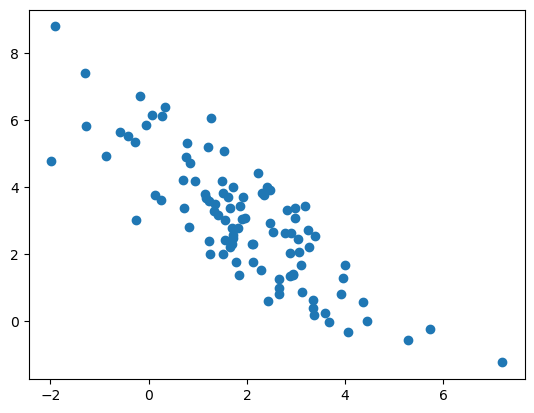

In [284]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])



### Visualize the centered data
Notice that the data visualized above is not centered on the origin (0,0). Use the function defined above to center the data, and the replot it.

In [288]:
import matplotlib.pyplot as plt

def plot_2D(X, title="2D Data", xlabel="Feature 1", ylabel="Feature 2", y=None, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if y is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
    else:
        plt.scatter(X[:, 0], X[:, 1], s=20)
    
    plt.axhline(0, color='grey', lw=1)
    plt.axvline(0, color='grey', lw=1)
    plt.axis('equal')
    plt.grid(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


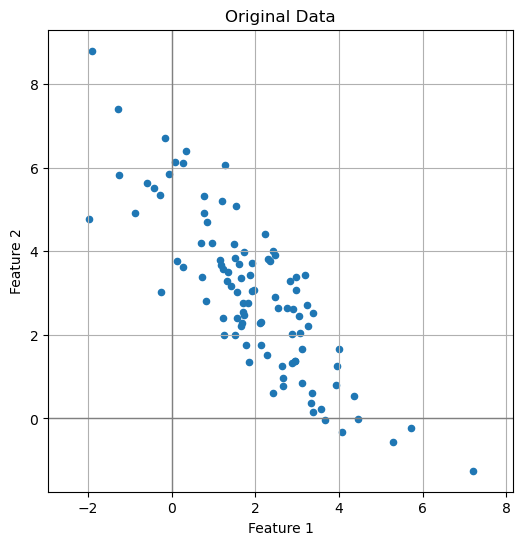

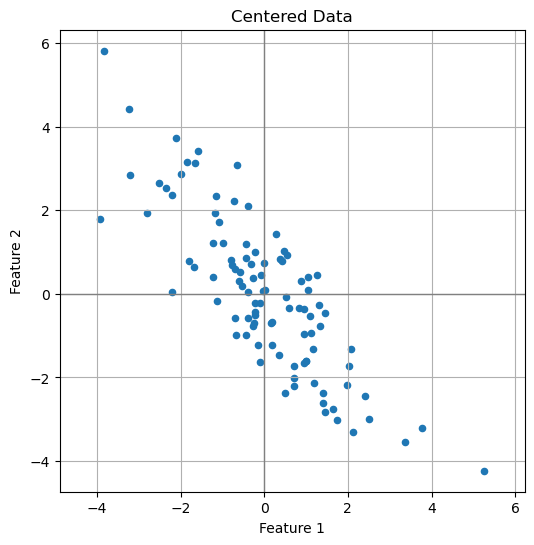

In [290]:
# Rådata
plot_2D(X, title="Original Data")

# Sentret
X_centered = center_data(X)
plot_2D(X_centered, title="Centered Data")




### Visualize the first eigenvector
Visualize the vector defined by the first eigenvector.
To do this you need:
- Use the *PCA()* function to recover the eigenvectors
- Plot the centered data as done above 
- The first eigenvector is a 2D vector (x0,y0). This defines a vector with origin in (0,0) and head in (x0,y0). Use the function *plot()* from matplotlib to plot a line over the first eigenvector.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


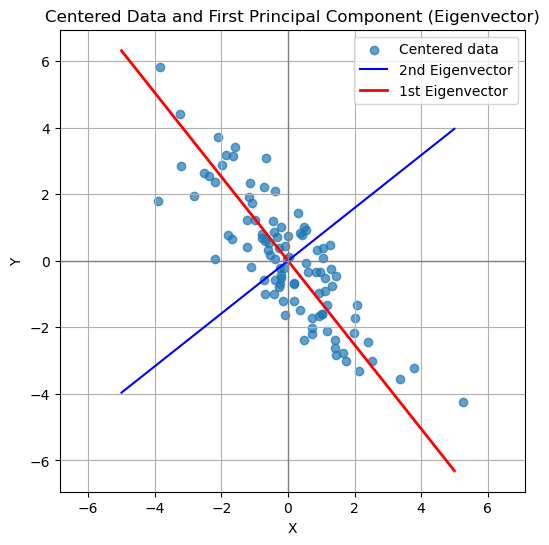

In [292]:
# Get original data and center it
X = data_assignment3.get_synthetic_data()
X_centered = center_data(X)

# PCA
W, _ = pca(X, m=X.shape[1])

#  Extract the first eigenvector 
first_eigvec = W[:, 0]  # shape: (2,)

#  Plot the centered data
plt.figure(figsize=(6, 6))
plt.scatter(X_centered[:, 0], X_centered[:, 1], alpha=0.7, label='Centered data')

# Plot the first eigenvector as a line through the origin
x = np.linspace(-5, 5, 1000)
slope = first_eigvec[1] / first_eigvec[0]  
y = slope * x

# Second eigenvector
second_eigvec = W[:, 1]
slope2 = second_eigvec[1] / second_eigvec[0]
y2 = slope2 * x
plt.plot(x, y2, color='blue', label='2nd Eigenvector')


plt.plot(x, y, color='red', linewidth=2, label='1st Eigenvector')


plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Centered Data and First Principal Component (Eigenvector)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()




### Visualize the PCA projection
Finally, use the *PCA()* algorithm to project on a single dimension and visualize the result using again the *scatter()* function.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


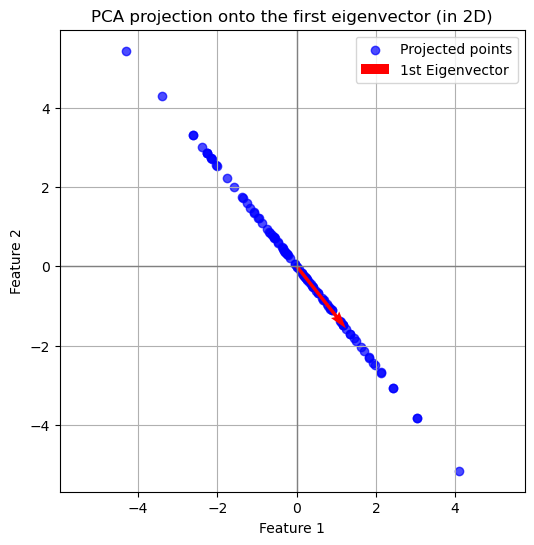

In [207]:
# Load and center the data
X = data_assignment3.get_synthetic_data()
X_centered = center_data(X)

# Perform PCA with only 1 component (for 1D projection)
W, X_pca = pca(X, m=1)  # W: [M x 1], X_pca: [N x 1]

#  Project back to 2D space from 1D (reconstruction in original space)
X_reconstructed = X_pca @ W.T  # shape: [N x 2]

#  Plot reconstructed (projected) points
plt.figure(figsize=(6, 6))
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1],
            alpha=0.7, label='Projected points', color='blue')

#  Draw first eigenvector from origin as arrow
first_eigvec = W[:, 0]
plt.quiver(0, 0, first_eigvec[0], first_eigvec[1],
           angles='xy', scale_units='xy', scale=0.5,
           color='red', label='1st Eigenvector', linewidth=2)

plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA projection onto the first eigenvector (in 2D)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


#changes


Tror dette er riktig, med mindre du må ha med 2 egenvektor 

## Part 1.3: Evaluation - When are the results of PCA sensible?
So far we have used PCA on synthetic data. Let us now imagine we are using PCA as a pre-processing step before a classification task. This is a common setup with high-dimensional data. We explore when the use of PCA is sensible.

### Loading the first set of labels
The function *get_synthetic_labeled_data_1()* from the module *data_assignment3* provides a first labeled dataset.

In [210]:
X, y = data_assignment3.get_synthetic_labeled_data_1()

### Running PCA
Process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


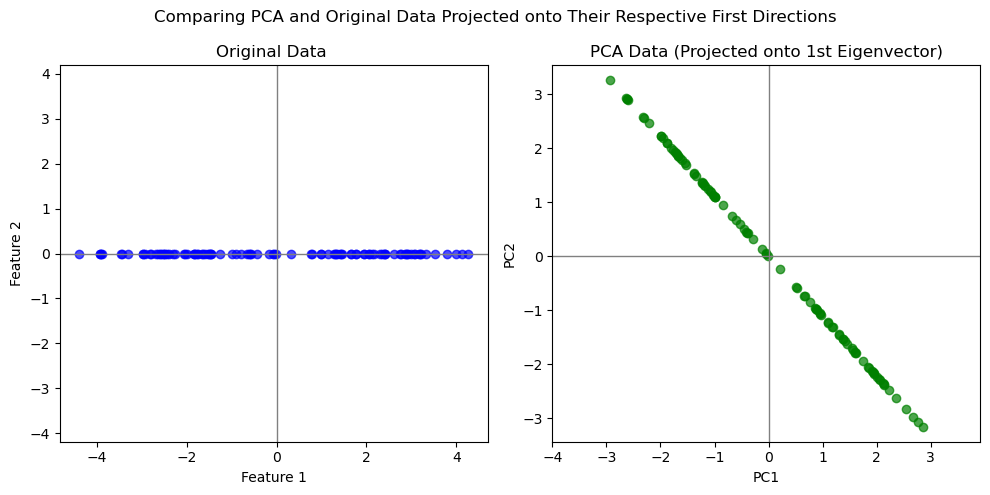

In [ ]:

X_centered = center_data(X)

#  Manually define a basis vector 
dimension = 0  #
basis_vector = np.zeros(X.shape[1])
basis_vector[dimension] = 1  

#  Project original data onto x-axis manually
projection_scalar = X_centered @ basis_vector  # shape: (N,)
X_projected = np.outer(projection_scalar, basis_vector)  # shape: (N x 2)

#  PCA projection (to 2D)
pca_eigvec, P = pca(X, m=2)  # project to 2D

# Project PCA-transformed data onto first principal component (manually)
pca_direction = pca_eigvec[:, 0]
pca_scalar = P @ pca_direction
P_projected = np.outer(pca_scalar, pca_direction)

#  Plot both side by side
plt.figure(figsize=(10, 5))

# Original projection
plt.subplot(1, 2, 1)
plt.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.7, color='blue')
plt.title('Original Data ')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# PCA projection
plt.subplot(1, 2, 2)
plt.scatter(P_projected[:, 0], P_projected[:, 1], alpha=0.7, color='green')
plt.title('PCA Data (Projected onto 1st Eigenvector)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

#
plt.suptitle('Comparing PCA and Original Data Projected onto Their Respective First Directions')
plt.tight_layout()
plt.show()


**Comment:** Add your comment here.
Comparing of data when projected onto different directions. 



### Loading the second set of labels
The function *get_synthetic_labeled_data_2()* from the module *data_assignment3* provides a second labeled dataset.

In [295]:
X, y = data_assignment3.get_synthetic_labeled_data_2()


### Running PCA
As before, process the data using the PCA algorithm and project it in one dimension. Plot the labeled data using *scatter()* before and after running PCA. Comment on the results.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


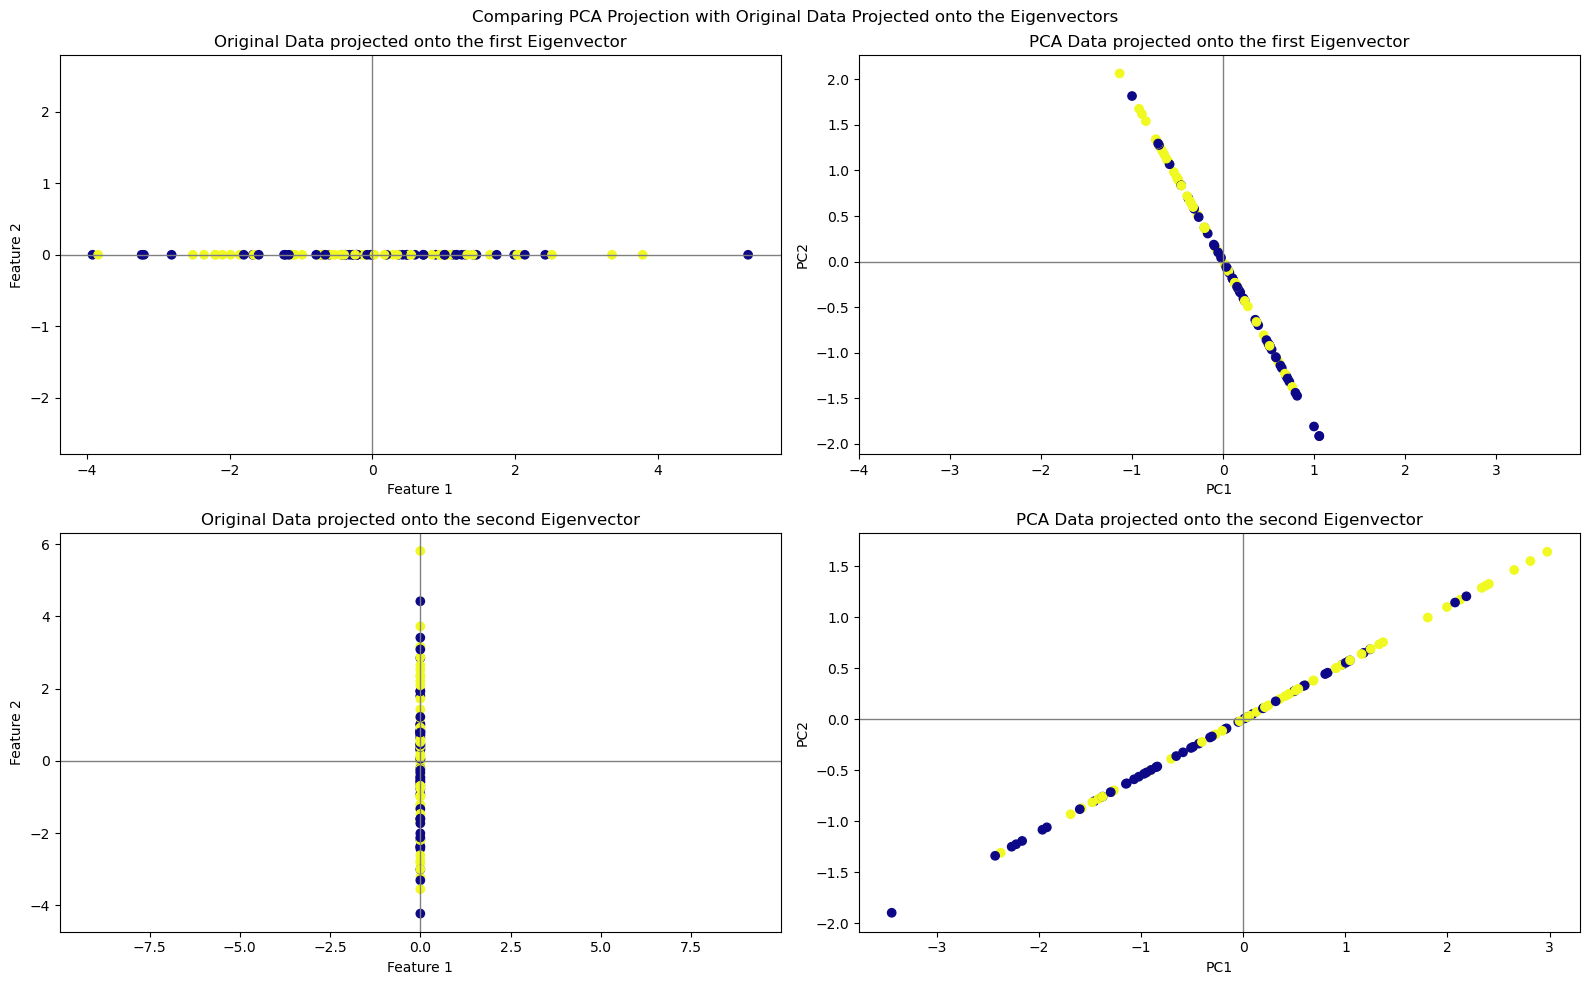

In [ ]:

#  PCA
m = X.shape[1]
pca_eigvec, X_pca = pca(X, m)


plt.figure(figsize=(16, 10))
cartesian_basis = np.eye(m)

#First dimension
dimension = 0
# Original data projected 
scalar_proj = X_centered @ cartesian_basis[dimension]
X_projected = np.outer(scalar_proj, cartesian_basis[dimension])
plt.subplot(2, 2, 1)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y[:, 0], cmap='plasma')
plt.title('Original Data projected onto the first Eigenvector')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# PCA data projected 
scalar_proj_pca = X_pca @ pca_eigvec[:, dimension]
P_projected = np.outer(scalar_proj_pca, pca_eigvec[:, dimension])
plt.subplot(2, 2, 2)
plt.scatter(P_projected[:, 0], P_projected[:, 1], c=y[:, 0], cmap='plasma')
plt.title('PCA Data projected onto the first Eigenvector')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

#Second dimension
dimension = 1
# Original data projected 
scalar_proj = X_centered @ cartesian_basis[dimension]
X_projected = np.outer(scalar_proj, cartesian_basis[dimension])
plt.subplot(2, 2, 3)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y[:, 0], cmap='plasma')
plt.title('Original Data projected onto the second Eigenvector')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# PCA data projected 
scalar_proj_pca = X_pca @ pca_eigvec[:, dimension]
P_projected = np.outer(scalar_proj_pca, pca_eigvec[:, dimension])
plt.subplot(2, 2, 4)
plt.scatter(P_projected[:, 0], P_projected[:, 1], c=y[:, 0], cmap='plasma')
plt.title('PCA Data projected onto the second Eigenvector')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)


plt.suptitle('Comparing PCA Projection with Original Data Projected onto the Eigenvectors')
plt.tight_layout()
plt.show()


#navn kanskje 


**Comment:** Add your comment here.

shows how projecting the data onto the standard basis vector differs from projecting it on the PCA directions 




How would the result change if you were to consider only the second eigenvector?
What about if you were to consider both eigenvectors?

**Answer**: Add your answer here.

Using only the second eigevector captures less variance and gives a less informative projection.
Using both preserves all the variance and structure, giving a full view of the data in PCA. 

## Part 1.4: Case study 1 - PCA for visualization

The [*iris* flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) is one of the oldest and best known data collections used for machine learning. It consists of 50 samples from each of three species of iris flowers (*Iris setosa, Iris virginica and Iris versicolor*). Four features were measured from each sample: sepal length, sepal width, petal length and petal width, all in centimeters.

Visualizing a 4-dimensional dataset is impossible; therefore we will use PCA to project our data in 2 dimensions and visualize it.

### Loading the data
The function *get_iris_data()* from the module *data_assignment3* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [300]:
X, y = data_assignment3.get_iris_data()

### Visualizing the data by selecting features
Try to visualize the data (using label information) by randomly selecting two out of the four features of the data. You may try different pairs of features.

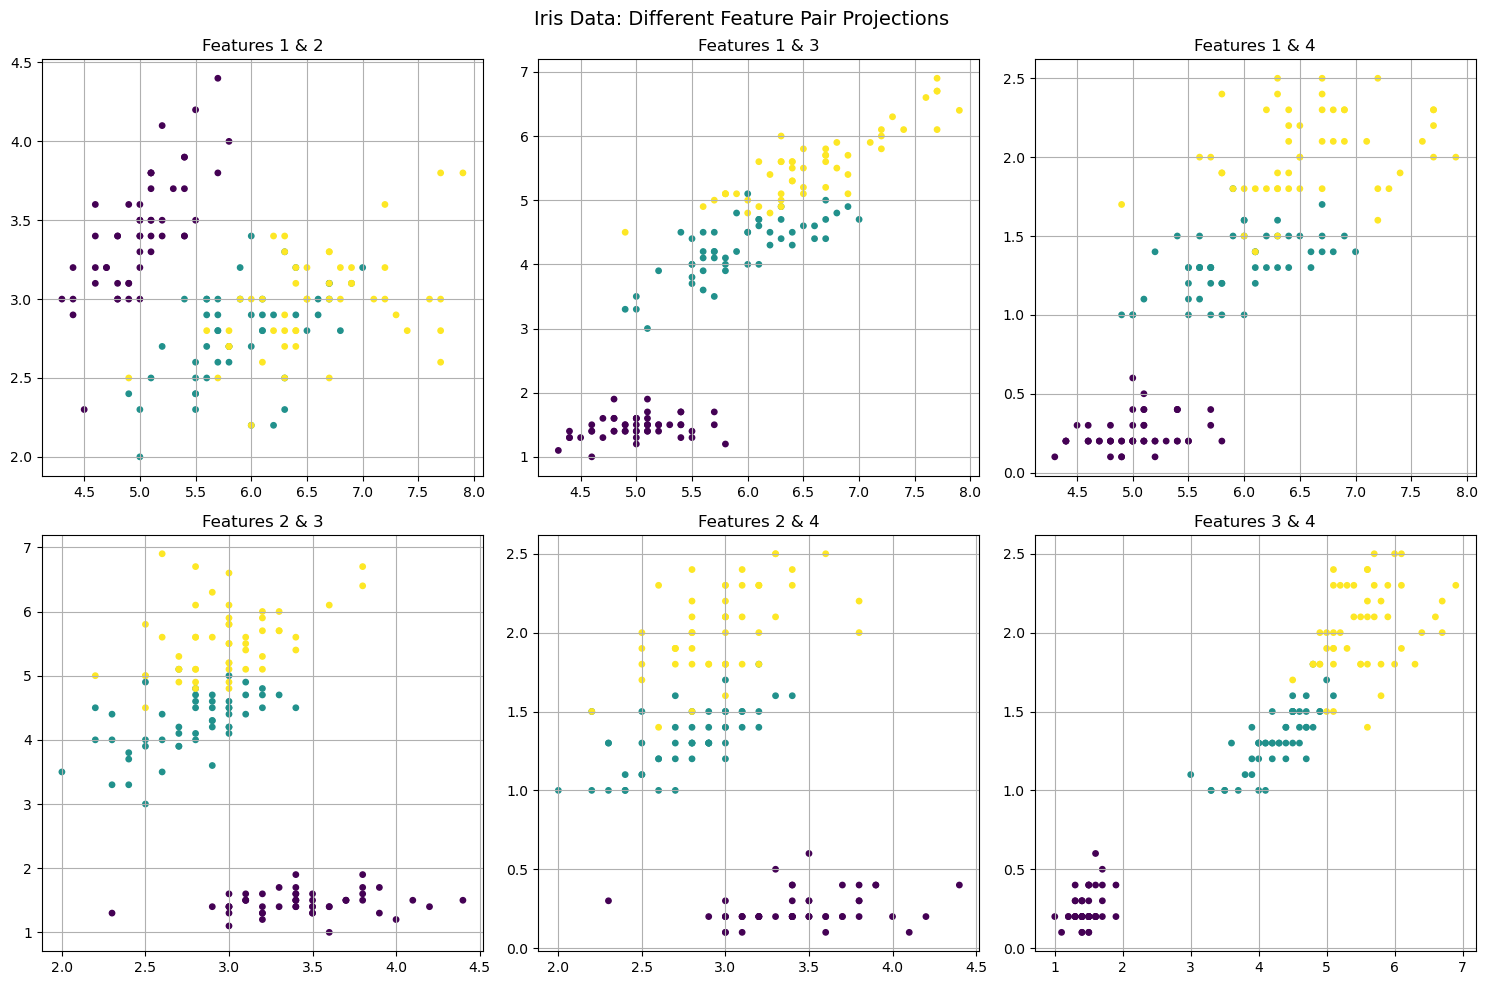

In [301]:

feature_pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

# Plot setup
plt.figure(figsize=(15, 10))

for i, (f1, f2) in enumerate(feature_pairs):
    plt.subplot(2, 3, i + 1)
    plt.scatter(X[:, f1], X[:, f2], c=y, cmap='viridis', s=15)  
    plt.title(f'Features {f1+1} & {f2+1}')
    plt.grid(True)

    # Optional: tighten axis limits slightly
    padding_x = (X[:, f1].max() - X[:, f1].min()) * 0.05
    padding_y = (X[:, f2].max() - X[:, f2].min()) * 0.05
    plt.xlim(X[:, f1].min() - padding_x, X[:, f1].max() + padding_x)
    plt.ylim(X[:, f2].min() - padding_y, X[:, f2].max() + padding_y)

plt.suptitle('Iris Data: Different Feature Pair Projections ', fontsize=14)
plt.tight_layout()
plt.show()


### Visualizing the data by PCA
Process the data using PCA and visualize it (using label information). Compare with the previous visualization and comment on the results.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


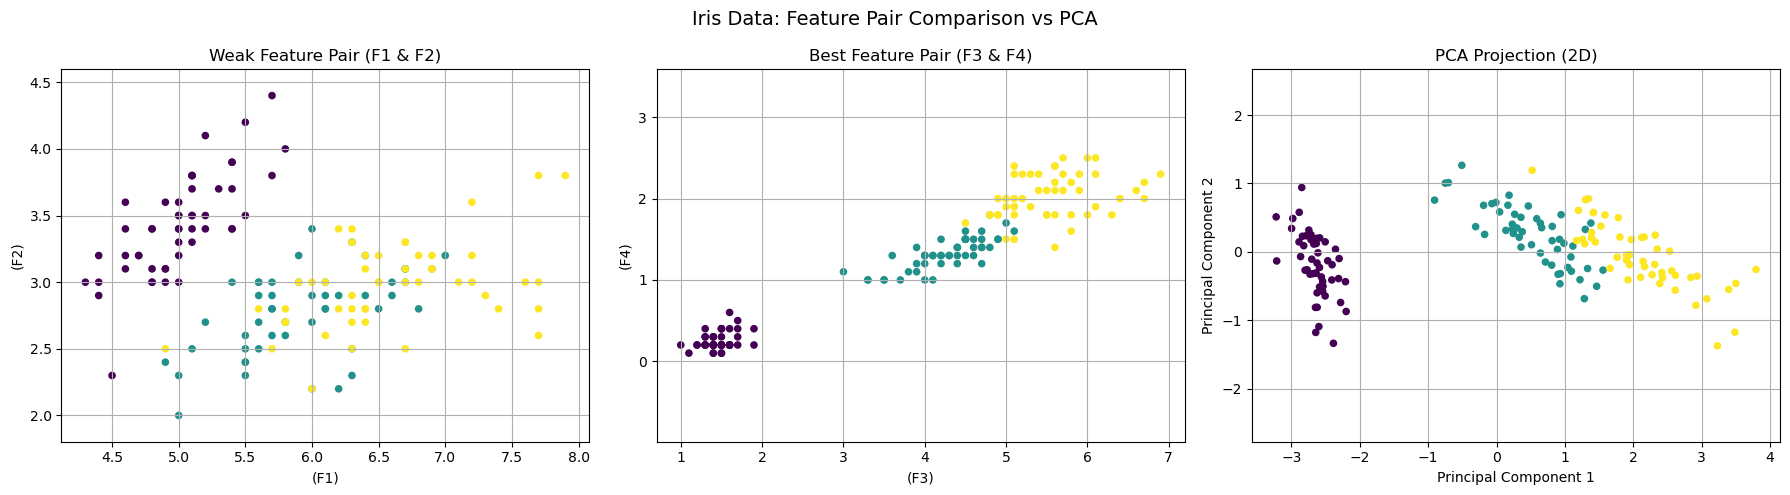

In [302]:
# Load iris data
X, y = data_assignment3.get_iris_data()

# Feature pairs
X_bad = X[:, [0, 1]]   
X_best = X[:, [2, 3]]  

# PCA to 2D
_, X_pca = pca(X, m=2)


plt.figure(figsize=(18, 5))

# Weak feature pair
plt.subplot(1, 3, 1)
plt.scatter(X_bad[:, 0], X_bad[:, 1], c=y, cmap='viridis', s=20)
plt.xlabel('(F1)')
plt.ylabel('(F2)')
plt.title('Weak Feature Pair (F1 & F2)')
plt.grid(True)
plt.axis('equal')

# Strong feature pair
plt.subplot(1, 3, 2)
plt.scatter(X_best[:, 0], X_best[:, 1], c=y, cmap='viridis', s=20)
plt.xlabel('(F3)')
plt.ylabel('(F4)')
plt.title('Best Feature Pair (F3 & F4)')
plt.grid(True)
plt.axis('equal')

# 3. PCA projection
plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D)')
plt.grid(True)
plt.axis('equal')

plt.suptitle('Iris Data: Feature Pair Comparison vs PCA', fontsize=14)
plt.tight_layout()
plt.show()


**Comment:** Enter your comment here.

The PCA projection offers the most balanced and separated view of the classes, using information from all four features.







In all cases we see how the PCA projection centers the data around the origin.
In the upper half we see the clearest separation of the classes. This is to be expected since the first eigenvector is the one that explains most of the variance in the data.

## Part 1.5: Case study 2 - PCA for compression
We now consider the *faces in the wild (lfw)* dataset, a collection of pictures (N=1280) of people. Each pixel in the image is a feature (M=2914).

### Loading the data
The function *get_lfw_data()* from the module *data_assignment3* returns the *lfw* dataset. It returns a data matrix of dimension [1280x2914] and a label vector of dimension [1280]. It also returns two parameters, $h$ and $w$, reporting the height and the width of the images (these parameters are necessary to plot the data samples as images). Beware, it might take some time to download the data. Be patient :) 

In [222]:

X, y, h, w = data_assignment3.get_lfw_data()


### Inspecting the data
Choose one datapoint to visualize (first coordinate of the matrix $X$) and use the function [imshow()](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) to plot and inspect some of the pictures.

Notice that the first argument of *imshow* is the image to be plotted; the image must be provided as a rectangular matrix, therefore we reshape a sample from the matrix $X$ to have height $h$ and width $w$. The parameter *cmap* specifies the color coding; in our case we will visualize the image in black-and-white with different gradations of grey.

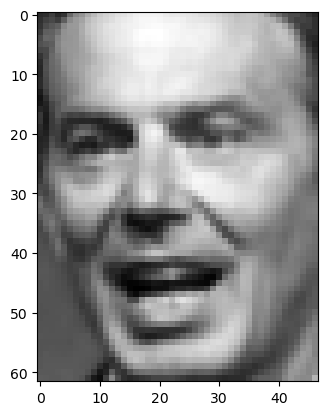

In [ ]:
image_number = 1  # display the 1 image of the collection
plt.imshow(X[image_number, :].reshape((h, w)), cmap=plt.cm.gray)

### Implementing a compression-decompression function
Implement a function that first uses PCA to project samples in low-dimensions, and then reconstruct the original image.

*Hint:* Most of the code is the same as the previous PCA() function you implemented.

In [223]:
def encode_decode_pca(A, m):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # m    integer number denoting the number of learned features (m <= M)
    #
    # OUTPUT:
    # Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    
    
   eigvec, X_proj = pca(A, m)

    # Step 2: Reconstruct from PCA@
   A_hat = X_proj @ eigvec.T

   return A_hat


### Compressing and decompressing the data
Use the implemented function to encode and decode the data by projecting on a lower dimensional space of dimension 200 (m=200).

In [224]:
Xhat = encode_decode_pca(X, m=200)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Inspecting the reconstructed data
Use the function *imshow* to plot and compare original and reconstructed pictures. Comment on the results.

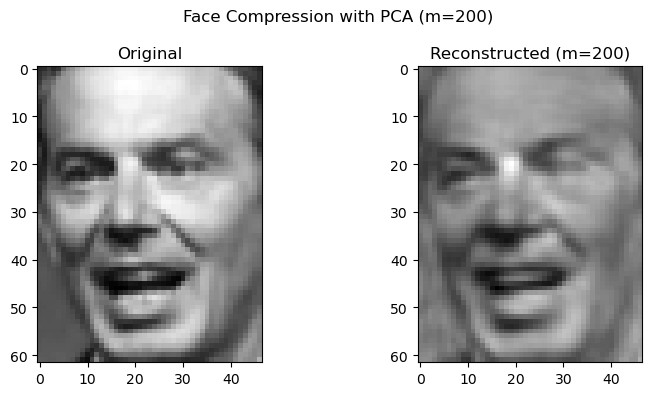

In [225]:
# Your code here
# change picture if you want 
image_number = 1

#rekonstruering 
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(X[image_number].reshape(h, w), cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(Xhat[image_number].reshape(h, w), cmap='gray')
plt.title('Reconstructed (m=200)')

plt.suptitle('Face Compression with PCA (m=200)')
plt.tight_layout()
plt.show()


**Comment:** Enter your comment here.
Reconstructed, but not as good as the original picture 

### Evaluating different compressions
Use the previous setup to generate compressed images using different values of low dimensions in the PCA algorithm (e.g.: 20, 100, 200, 500, 1000). Plot and comment on the results. You can use `plt.subplot(n_rows, n_cols, position)` and `plt.title(titlestring)` to get a nice plot.

In [226]:
# Your code here
compressions = [20, 100, 200, 500, 1000]
images = [encode_decode_pca(X, m) for m in compressions]

#no changes

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


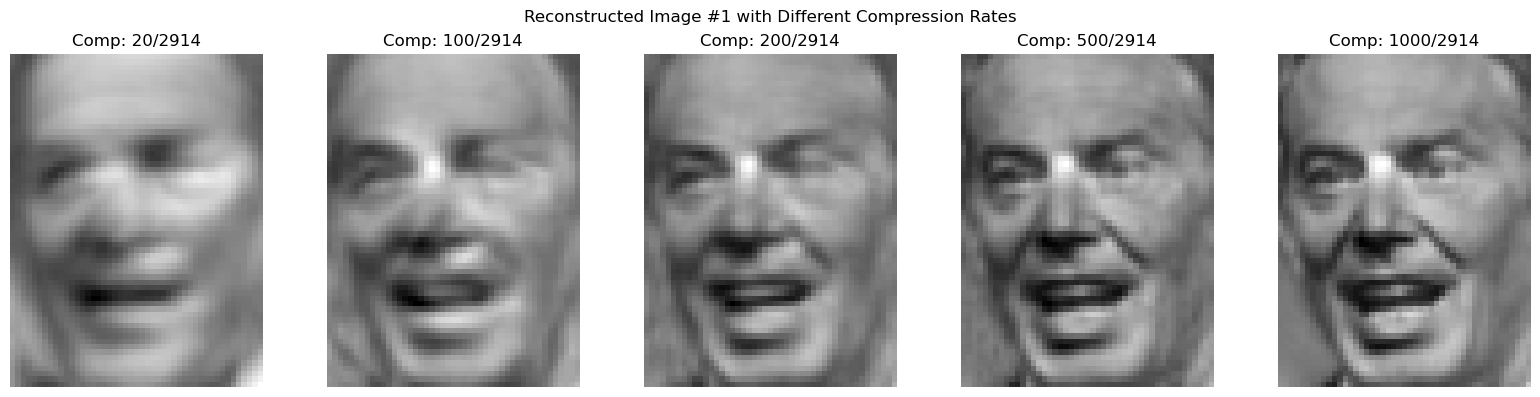

In [ ]:

#X, y, h, w = data_assignment3.get_lfw_data()

# Set image index and compression values
image_idx = 1
compression_levels = [20, 100, 200, 500, 1000]

# Reconstruct image using different PCA dimensions
reconstructions = []
for m in compression_levels:
    X_hat = encode_decode_pca(X, m)
    reconstructions.append(X_hat[image_idx].reshape(h, w))

# Plot all reconstructions
plt.figure(figsize=(16, 4))

for i, img in enumerate(reconstructions):
    plt.subplot(1, len(compression_levels), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Comp: {compression_levels[i]}/2914')
    plt.axis('off')

plt.suptitle(f'Reconstructed Image #{image_idx}')
plt.tight_layout()
plt.show()


**Comment:** Enter your comment here.
We see a clear trend of improving quality of the images as we increase the number of dimensions.

## Part 1.6: PCA tuning (compulsory for Master students only)
If we use PCA for compression or decompression, it may be not trivial to decide how many dimensions to keep. In this section we review a principled way to decide how many dimensions to keep.

The number of dimensions to keep is the only *hyper-parameter* of PCA. A method designed to decide how many dimensions/eigenvectors is the *proportion of variance*:
$$ \textrm{POV}=\frac{\sum_{i=1}^{m}{\lambda_{i}}}{\sum_{j=1}^{M}{\lambda_{j}}}, $$
where $\lambda$ are eigenvalues, $M$ is the dimensionality of the original data, and $m$ is the chosen lower dimensionality. 

Using the $POV$ formula we may select a number $m$ of dimensions/eigenvalues so that the proportion of variance is, for instance, equal to 95%.

Implement a new PCA for encoding and decoding that receives in input not the number of dimensions for projection, but the amount of proportion of variance to be preserved.

In [228]:
def encode_decode_pca_with_pov(A, p):
    # INPUT:
    # A    [NxM] numpy data matrix (N samples, M features)
    # p    float number between 0 and 1 denoting the POV to be preserved
    #
    # OUTPUT:
    # Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    # m    integer reporting the number of dimensions selected
    
    #  Center data
    A_mean = np.mean(A, axis=0)
    A_centered = A - A_mean

    #  Covariance matrix
    C = compute_covariance_matrix(A)

    # Eigendecomposition
    eigvals, eigvecs = compute_eigenvalue_eigenvectors(C)
    eigvals, eigvecs = sort_eigenvalue_eigenvectors(eigvals, eigvecs)

    # Select m such that POV ≥ p
    total_variance = np.sum(eigvals)
    cumulative_variance = np.cumsum(eigvals)
    m = np.searchsorted(cumulative_variance / total_variance, p) + 1

    # Step 5: Reduce and reconstruct
    W = eigvecs[:, :m]  # top m eigenvectors
    Z = (A_centered @ W)         # projected
    W_hat = Z @ W.T + A_mean     # reconstructed

    return W_hat, m


Import the `lfw` dataset again. Use the implemented function to encode and decode the data by projecting on a lower dimensional space such that `POV=0.95`. Use the function `imshow` to plot and compare original and reconstructed pictures. Comment on the results.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Selected dimensions: 184


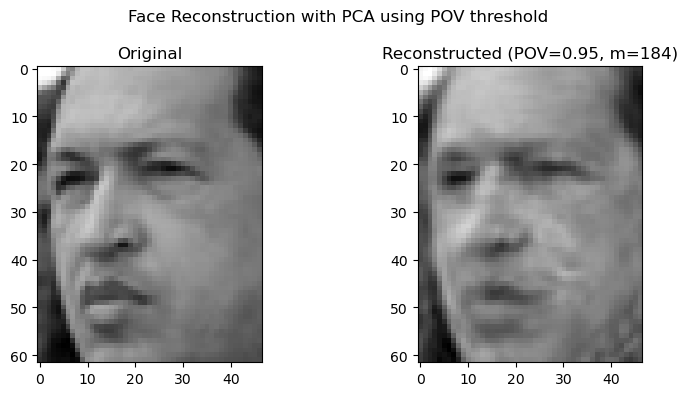

In [229]:
# Load data
X, y, h, w = data_assignment3.get_lfw_data()

# Compress with POV = 0.95
Xhat, m = encode_decode_pca_with_pov(X, p=0.95)
print("Selected dimensions:", m)

# Show original and reconstructed
image_id = 0
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X[image_id].reshape(h, w), cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(Xhat[image_id].reshape(h, w), cmap='gray')
plt.title(f'Reconstructed (POV=0.95, m={m})')

plt.suptitle('Face Reconstruction with PCA using POV threshold')
plt.tight_layout()
plt.show()


**Comment:** Enter your comment here.
Using POV = 0.95 automatically selected m = [X], which balances compression and quality.
The reconstructed image retains most facial features, with minimal loss of detail.


# Part 2: K-Means Clustering
In this section you will use the *k-means clustering* algorithm to perform unsupervised clustering. Then you will perform a qualitative assessment of the results.

## Part 2.1: Applying K-Means and Qualitative Assessment

### Importing scikit-learn library
We start importing the module `sklearn.cluster.KMeans` from the standard machine learning library `scikit-learn`.

In [169]:
from sklearn.cluster import KMeans

### Loading the data
We will use once again the *iris* data set. Start by loading the dataset again.

In [170]:
X, y = data_assignment3.get_iris_data()

### Projecting the data using PCA
To allow for visualization, we project our data in two dimensions as we did previously. This step is not necessary, and we may want to try to use *k-means* later without the PCA pre-processing. But to start, we use PCA, as this will allow for an easy visualization.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


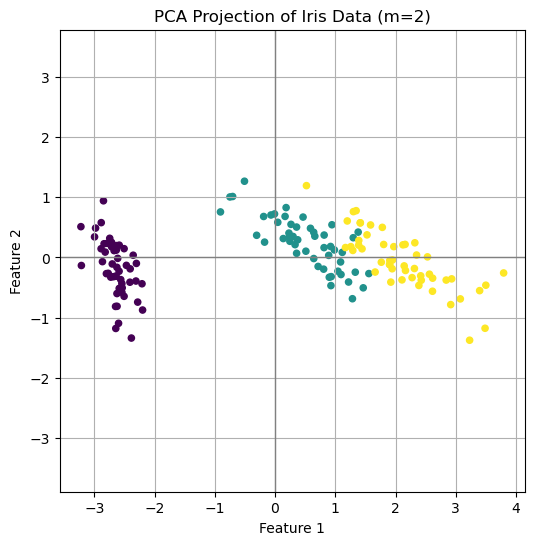

In [171]:
# Your code here


# PCA to 2D
_, P = pca(X, m=2)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(P[:, 0], P[:, 1], c=y, cmap='viridis', s=20)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA Projection of Iris Data (m=2)')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)
plt.axis('equal')
plt.show()

### Running k-means
Use the class *KMeans* to fit and predict the output of the *k-means* algorithm on the projected data (note that we don't use the true labels `y` here). Run the algorithm using the following values of $k=\{2,3,4,5\}$. 

### Qualitative assessment
Plot the results of running the k-means algorithm, compare with the true labels, and comment.

In [231]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# PCA-redusert data P og sanne etiketter y
k_values = [2, 3, 4, 5]
pca_eigvec, P = pca(X, m=2)


# KMeans-prediksjoner for hver k-verdi
y_hats = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(P)
    for k in k_values]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


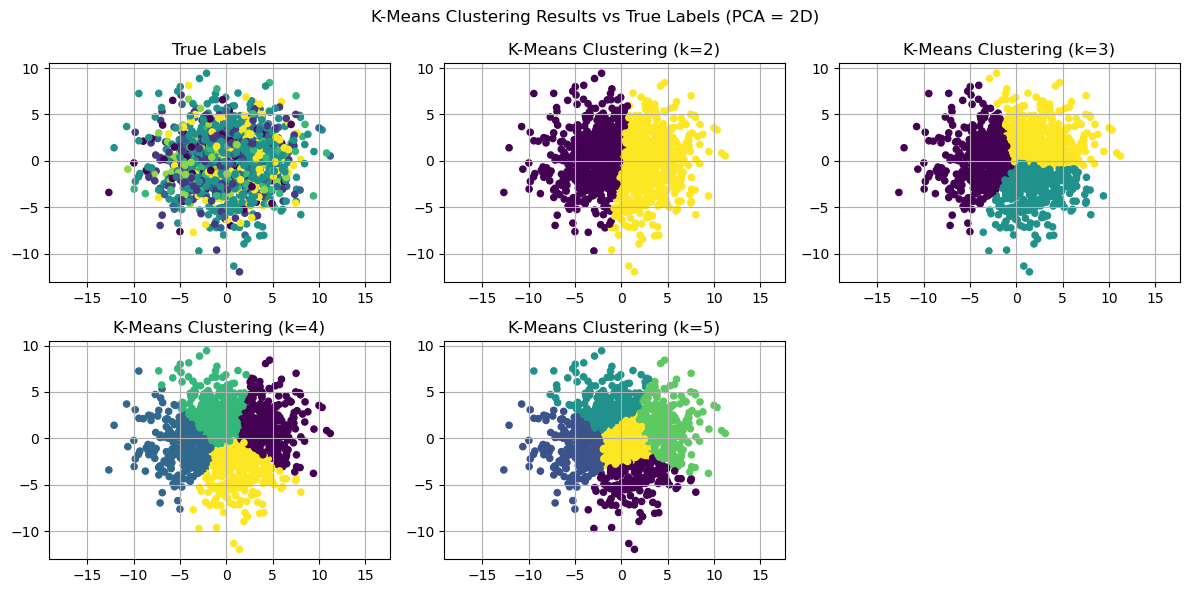

In [232]:



plt.figure(figsize=(12, 6))

# Plot true labels
plt.subplot(2, 3, 1)
plt.scatter(P[:, 0], P[:, 1], c=y, cmap='viridis', s=20)
plt.title("True Labels")
plt.axis("equal")
plt.grid(True)

# Plot KMeans clusters for each k
for i, (k, y_hat) in enumerate(zip(k_values, y_hats)):
    plt.subplot(2, 3, i + 2)
    plt.scatter(P[:, 0], P[:, 1], c=y_hat, cmap='viridis', s=20)
    plt.title(f"K-Means Clustering (k={k})")
    plt.axis("equal")
    plt.grid(True)

plt.suptitle("K-Means Clustering Results vs True Labels (PCA = 2D)", fontsize=12)
plt.tight_layout()
plt.show()


**Comment:** Enter your comment here. The best clustering match occurs at k=3, which aligns with the three true Iris species.




## Part 2.2: Quantitative Assessment of K-Means

Above, we used k-means for clustering and assessed the results qualitatively by visualizing them. However, we often want to measure in a quantitative way how good a clustering is. To do this, we will use a classification task to **evaluate numerically how good the learned clusters are for all the different values of k you used above (2 to 5)**.

Informally, our evaluation will work as follows: For each of our clusterings ($k=2$ to $k=5$), we will try to learn a mapping from the identified clusters to the correct labels of our datapoints. The reason this can be a sensible evaluation, is that to learn a good mapping, we have to have identified clusters that correspond to the actual classes in our data. We will in other words train 4 different classification models (one for each $k$ value), where the input to our classifier is the cluster each datapoint belongs to, and the target is the correct class for this datapoint. In other words, **we aim to learn to classify datapoints as well as possible with the only information available to the classifier being the cluster that datapoint belongs to**. For some values of k, we will get poorly performing classifiers, indicating that this clustering has not revealed the correct class division in our data.

In practice, you will do the following: Reload the *iris* dataset. Import a standard `LogisticRegression` classifier from the module `sklearn.linear_model`. Use the k-means representations learned previously (`yhats[2],...,yhats[5]`) and the true label to train the classifier. Evaluate your model on the training data (we do not have a test set, so this procedure will assess the model fit instead of generalization) using the `accuracy_score()` function from the `sklearn.metrics` module. Plot a graph showing how the accuracy score varies when changing the value of $k$. Comment on the results.

- Train a Logistic regression model using the first two dimensions of the PCA of the iris data set as input, and the true classes as targets.
- Report the model fit/accuracy on the training set.
- For each value of K:
  - One-Hot-Encode the classes outputed by the K-means algorithm.
  - Train a Logistic regression model on the K-means classes as input vs the real classes as targets.
  - Calculate model fit/accuracy vs. value of K.
- Plot your results in a graph and comment on the K-means fit.

In [270]:

X, y = data_assignment3.get_iris_data()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
k=2, accuracy=0.667, shape=(150, 2)
k=3, accuracy=0.887, shape=(150, 3)
k=4, accuracy=0.847, shape=(150, 4)
k=5, accuracy=0.907, shape=(150, 5)


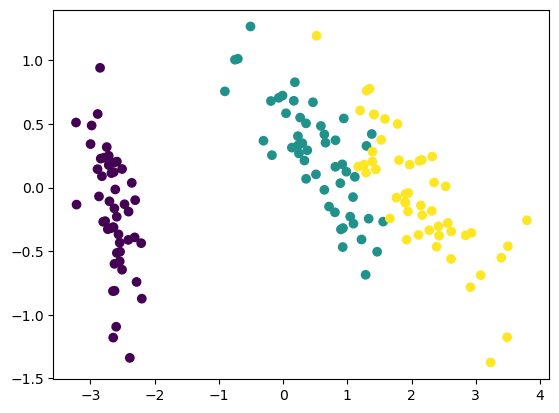

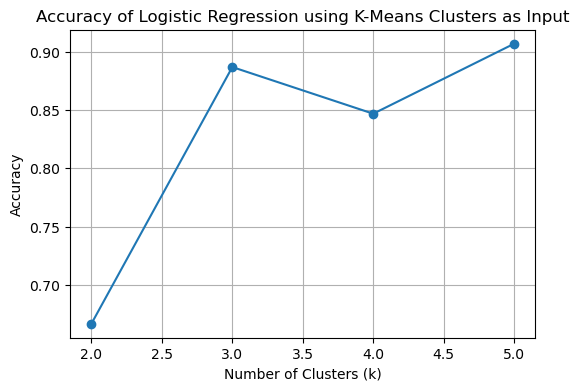

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans



_, P = pca(X, 2)


# Recreate KMeans clusterings on PCA output
k_range = [2, 3, 4, 5]
y_hats = [KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(P) for k in k_range]




# Accuracy evaluation
accuracies = []

for i, y_hat in enumerate(y_hats):
    encoder = OneHotEncoder(sparse_output=False)
    X_cluster = encoder.fit_transform(y_hat.reshape(-1, 1))
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_cluster, y)
    
    y_pred = clf.predict(X_cluster)
    acc = accuracy_score(y, y_pred)
    print(f"k={k_range[i]}, accuracy={acc:.3f}, shape={X_cluster.shape}")
    accuracies.append(acc)

    
plt.figure(figsize=(6, 4))
plt.plot(k_range, accuracies, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy of Logistic Regression using K-Means Clusters as Input")
plt.grid(True)
plt.show()





**Comment:** Add your comment here.
Er bare 3 arter i datasettet så gir mening at den går opp på 3, men skjønner ikke helt hvorfor den går ned på 4 og opp igjen, tenkte den skulle stabilisere seg litt. Kan hende det er en følge feil. dobbel sjekk. 

# Conclusions 

In this notebook we studied **unsupervised learning** considering two important and representative algorithms: **PCA** and **k-means**.

First, we implemented the PCA algorithm step by step; we then ran the algorithm on synthetic data in order to see its working and evaluated when it makes sense to use it and when it doesn't. We then considered two typical uses of PCA: for **visualization** on the *iris* dataset, and for **compression-decompression** on the *lfw* dataset. We also looked at an additional question that arises when using PCA: the problem of **selection of hyper-parameters**, that is, how to select the optimal hyper-parameter of our algorithm for a particular task.

We then moved to consider the k-means algorithm. In this case we used the implementation provided by *scikit-learn* and applied it to another prototypical unsupervised learning problem: **clustering**. We processed the *iris* dataset with *k-means* and evaluated the results visually. We also considered the problem of **quantitative evaluation** of the results, that is, how to measure the performance or usefulness of k-means clustering on a downstream task (classifying the *iris* samples into their species).